# Multiple Linear Regression Model

In [1]:
# Dependencies and setup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

In [2]:
# Set maximum rows to a high number
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 150)

In [3]:
# Load training dataset
training_data = pd.read_csv("02-cleaned_data/cleaned_training.csv",index_col=0)

In [4]:
# Drop extreme outliers
training_data.drop(index = training_data[(training_data.GrLivArea>4000) & (training_data.SalePrice<300000)].index.tolist(), inplace=True)

In [5]:
# Define a "TotLivingSF" variable that takes all the livable square feet in a home
training_data["TotLivingSF"] = training_data["GrLivArea"] + training_data["TotalBsmtSF"] - training_data["LowQualFinSF"]

# training_data["FullBath"] = training_data["FullBath"] + training_data["BsmtFullBath"]
# training_data["HalfBath"] = training_data["HalfBath"] + training_data["BsmtHalfBath"]
# Separate "YearBuilt" into multiple bins and define the separations as "YearBuiltBin"
year_bins = [0,1920,1940,1960,1980,2000,2020]
year_groups = ["pre_1920","1920_1940","1940_1960","1960_1980","1980_2000","2000_up"]
training_data["YearBuiltBin"] = pd.cut(training_data["YearBuilt"],year_bins,labels=year_groups)

In [6]:
# Reduce dataframe to only the relevant columns
training_data = training_data[["TotLivingSF","MSSubClass","LotFrontage","LotArea","MasVnrArea","Neighborhood","OverallQual","OverallCond","YearBuilt","ExterQual","BsmtQual","BsmtCond","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","KitchenQual","TotRmsAbvGrd","Fireplaces","FireplaceQu","GarageType","GarageCars","GarageArea","GarageQual","GarageCond","PoolQC","YrSold","SaleCondition","YearBuiltBin","SalePrice"]]

In [7]:
training_data["YearBuiltBin"].replace({"pre_1920":0,"1920_1940":1,"1940_1960":2,"1960_1980":3,"1980_2000":4,"2000_up":5},inplace=True)
training_data["ExterQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
training_data["BsmtQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
training_data["KitchenQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
training_data["FireplaceQu"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
training_data["GarageQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)

In [8]:
data = training_data.iloc[:,:-1]
data_encoded = pd.get_dummies(data,columns=["MSSubClass","Neighborhood","GarageType"],drop_first = True)

In [9]:
# data_encoded["YearBuiltBin"].replace({"pre_1920":0,"1920_1940":1,"1940_1960":2,"1960_1980":3,"1980_2000":4,"2000_up":5},inplace=True)
# data_encoded["ExterQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
# data_encoded["BsmtQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
# data_encoded["KitchenQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
# data_encoded["FireplaceQu"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
# data_encoded["GarageQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)

In [10]:
# Perform logarithmic transformation on columns
data_encoded[["TotLivingSF","GrLivArea","1stFlrSF"]] = np.log(data_encoded[["TotLivingSF","GrLivArea","1stFlrSF"]])
# Perform logarithmic transformation on columns with 0s
data_encoded["TotalBsmtSF"] = np.log(data_encoded["TotalBsmtSF"].replace(0, np.nan))
data_encoded.update(data_encoded["TotalBsmtSF"].fillna(0))

# Perform square root transformation on relevant columns
data_encoded["2ndFlrSF"] = np.sqrt(data_encoded["2ndFlrSF"])

# Perform cube root transformation on relevant columns
data_encoded[["LotFrontage","MasVnrArea"]] = np.cbrt(data_encoded[["LotFrontage","MasVnrArea"]])

# Perform cube root transformation on relevant columns
data_encoded["OverallQual"] = np.square(data_encoded["OverallQual"])

In [11]:
# Vector of dependent variable (home sale price)
y = np.log(training_data.iloc[:,-1].values)

## Verify Assumptions

### Assumption #1: Linearity
* The relationship between the dependent variable (log(HomePrice)) and the many independent variables is generally linear. However, the relationship is stronger with some independent variables than others

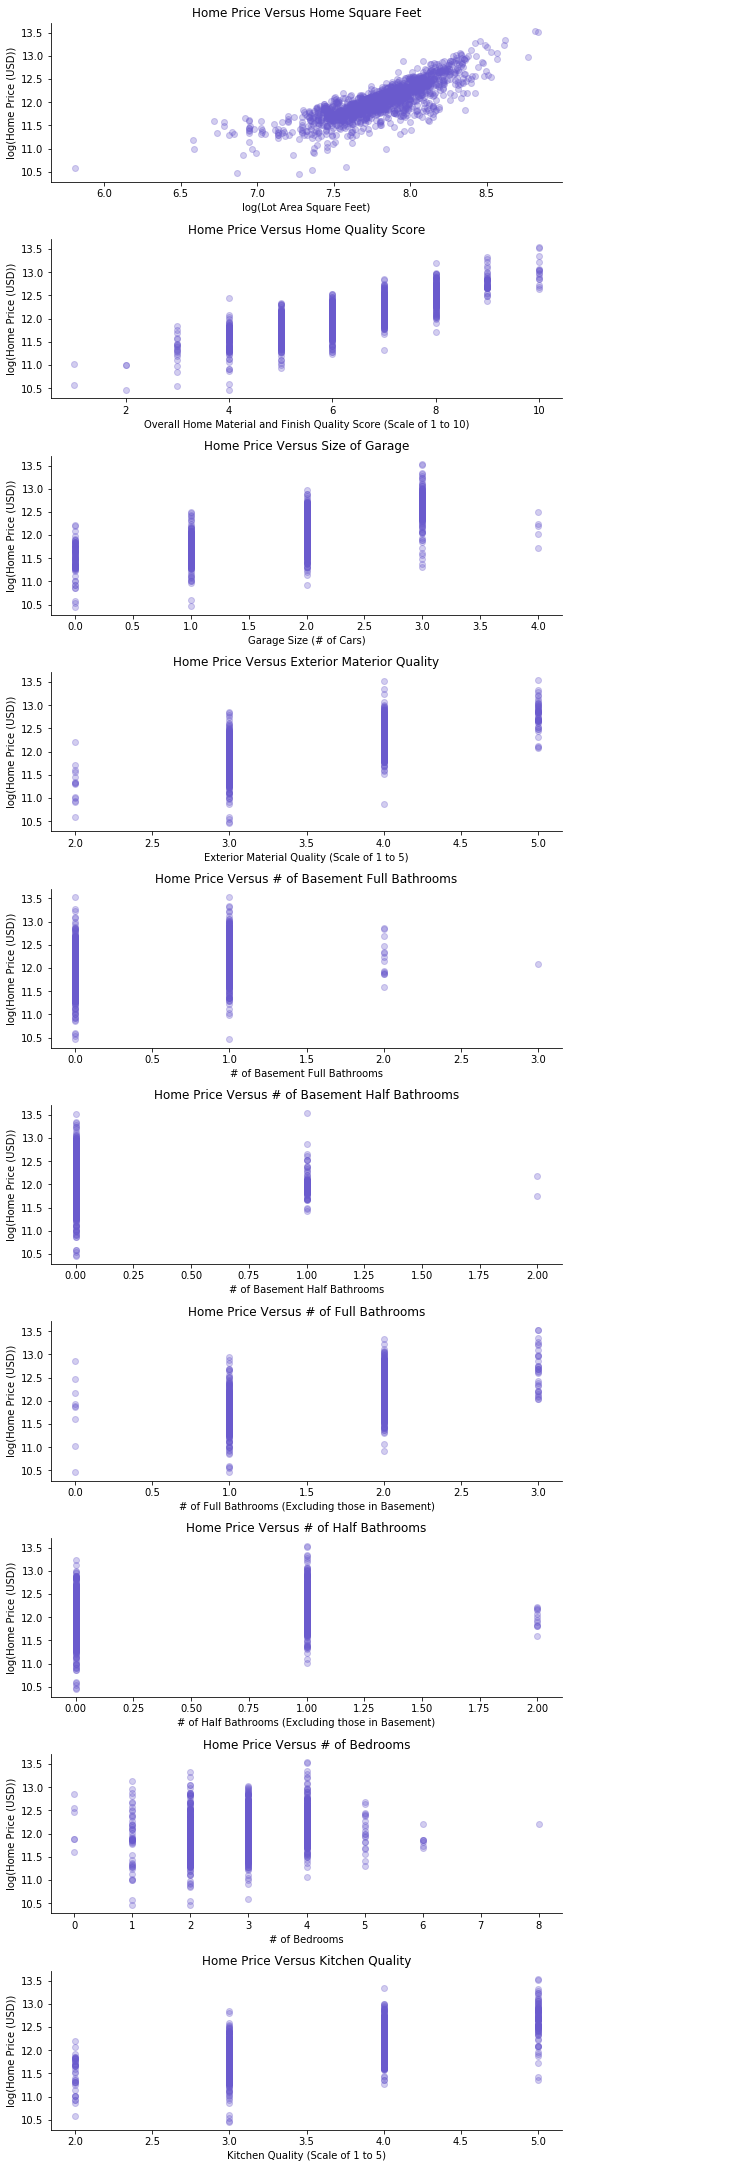

In [12]:
# Establish figure and grid to create two charts in the same image
lot_area_fig = plt.figure(constrained_layout=True,figsize=(10,30))
lot_area_grid = gridspec.GridSpec(ncols=3,nrows=10,figure=lot_area_fig)

# Create boxplot of square feet data
ax1 = lot_area_fig.add_subplot(lot_area_grid[0, :2])
ax1.set_title("Home Price Versus Home Square Feet")
plt.scatter(np.log(training_data['TotLivingSF']),np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("log(Lot Area Square Feet)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

# Create boxplot of log of square feet data
ax2 = lot_area_fig.add_subplot(lot_area_grid[1, :2])
ax2.set_title("Home Price Versus Home Quality Score")
plt.scatter(training_data['OverallQual'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("Overall Home Material and Finish Quality Score (Scale of 1 to 10)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax3 = lot_area_fig.add_subplot(lot_area_grid[2, :2])
ax3.set_title("Home Price Versus Size of Garage")
plt.scatter(training_data['GarageCars'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("Garage Size (# of Cars)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax4 = lot_area_fig.add_subplot(lot_area_grid[3, :2])
ax4.set_title("Home Price Versus Exterior Materior Quality")
plt.scatter(training_data['ExterQual'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("Exterior Material Quality (Scale of 1 to 5)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax5 = lot_area_fig.add_subplot(lot_area_grid[4, :2])
ax5.set_title("Home Price Versus # of Basement Full Bathrooms")
plt.scatter(training_data['BsmtFullBath'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("# of Basement Full Bathrooms")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax6 = lot_area_fig.add_subplot(lot_area_grid[5, :2])
ax6.set_title("Home Price Versus # of Basement Half Bathrooms")
plt.scatter(training_data['BsmtHalfBath'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("# of Basement Half Bathrooms")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax7 = lot_area_fig.add_subplot(lot_area_grid[6, :2])
ax7.set_title("Home Price Versus # of Full Bathrooms")
plt.scatter(training_data['FullBath'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("# of Full Bathrooms (Excluding those in Basement)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax8 = lot_area_fig.add_subplot(lot_area_grid[7, :2])
ax8.set_title("Home Price Versus # of Half Bathrooms")
plt.scatter(training_data['HalfBath'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("# of Half Bathrooms (Excluding those in Basement)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax9 = lot_area_fig.add_subplot(lot_area_grid[8, :2])
ax9.set_title("Home Price Versus # of Bedrooms")
plt.scatter(training_data['BedroomAbvGr'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("# of Bedrooms")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()

ax10 = lot_area_fig.add_subplot(lot_area_grid[9, :2])
ax10.set_title("Home Price Versus Kitchen Quality")
plt.scatter(training_data['KitchenQual'],np.log(training_data['SalePrice']),color="slateblue",alpha=0.3)
plt.xlabel("Kitchen Quality (Scale of 1 to 5)")
plt.ylabel("log(Home Price (USD))")
plt.grid(False)
sns.despine()


# Display the charts
plt.show()

### Assumption #2: Mean of Residuals is Zero
* The residual plot of the regression reveals that the mean of the errors tends to be very close to 0

Training Score: 0.8730511006368548
Testing Score: 0.8986539925078173
MSE: 0.017175570158083214


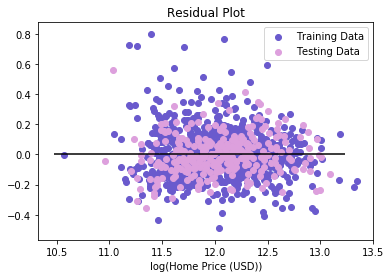

In [13]:
# Define the variables for the multiple linear regression
X_6 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste","BedroomAbvGr","Neighborhood_OldTown","ExterQual","Neighborhood_MeadowV"
# Redefine X
X = X_6.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)

### BEGIN SOLUTION
training_score = regressor.score(X_train, y_train)
testing_score = regressor.score(X_test, y_test)
MSE = mean_squared_error(y_test,y_pred)
### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print(f"MSE: {MSE}")
### BEGIN SOLUTION
# predictions = model.predict(X_test_scaled)
# model.fit(X_train_scaled, y_train_scaled)
# plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c="slateblue", label="Training Data")
plt.scatter(y_pred, y_pred - y_test, c="plum", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.xlabel("log(Home Price (USD))")
plt.show()
### END SOLUTION

### Assumption #3: Homoscedasticity
* Homoscedasticity means that the error term is the same across all the independent variables
* The above residuals plot shows that the errors are relatively homoscedastic

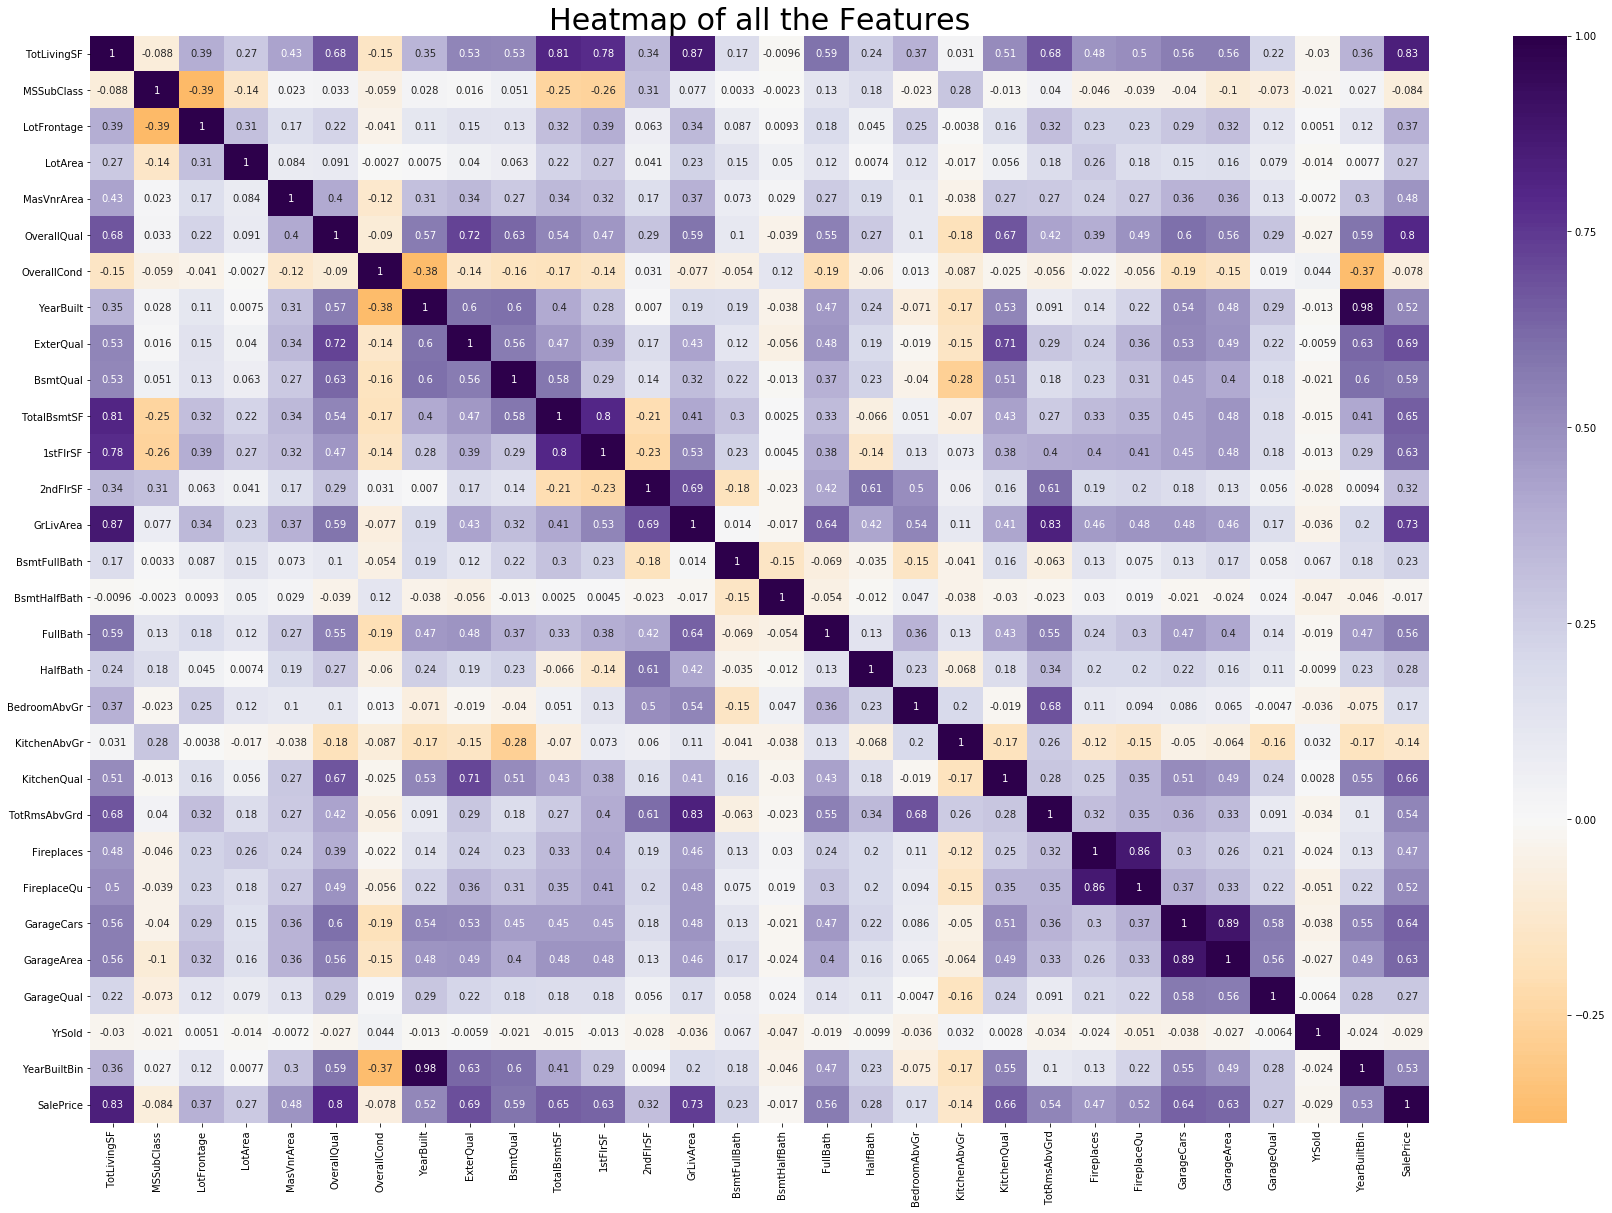

In [14]:
## Plot fig sizing. 
plt.subplots(figsize = (30,20))
## Plotting heatmap. 
sns.heatmap(training_data.corr(), cmap="PuOr", annot=True, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

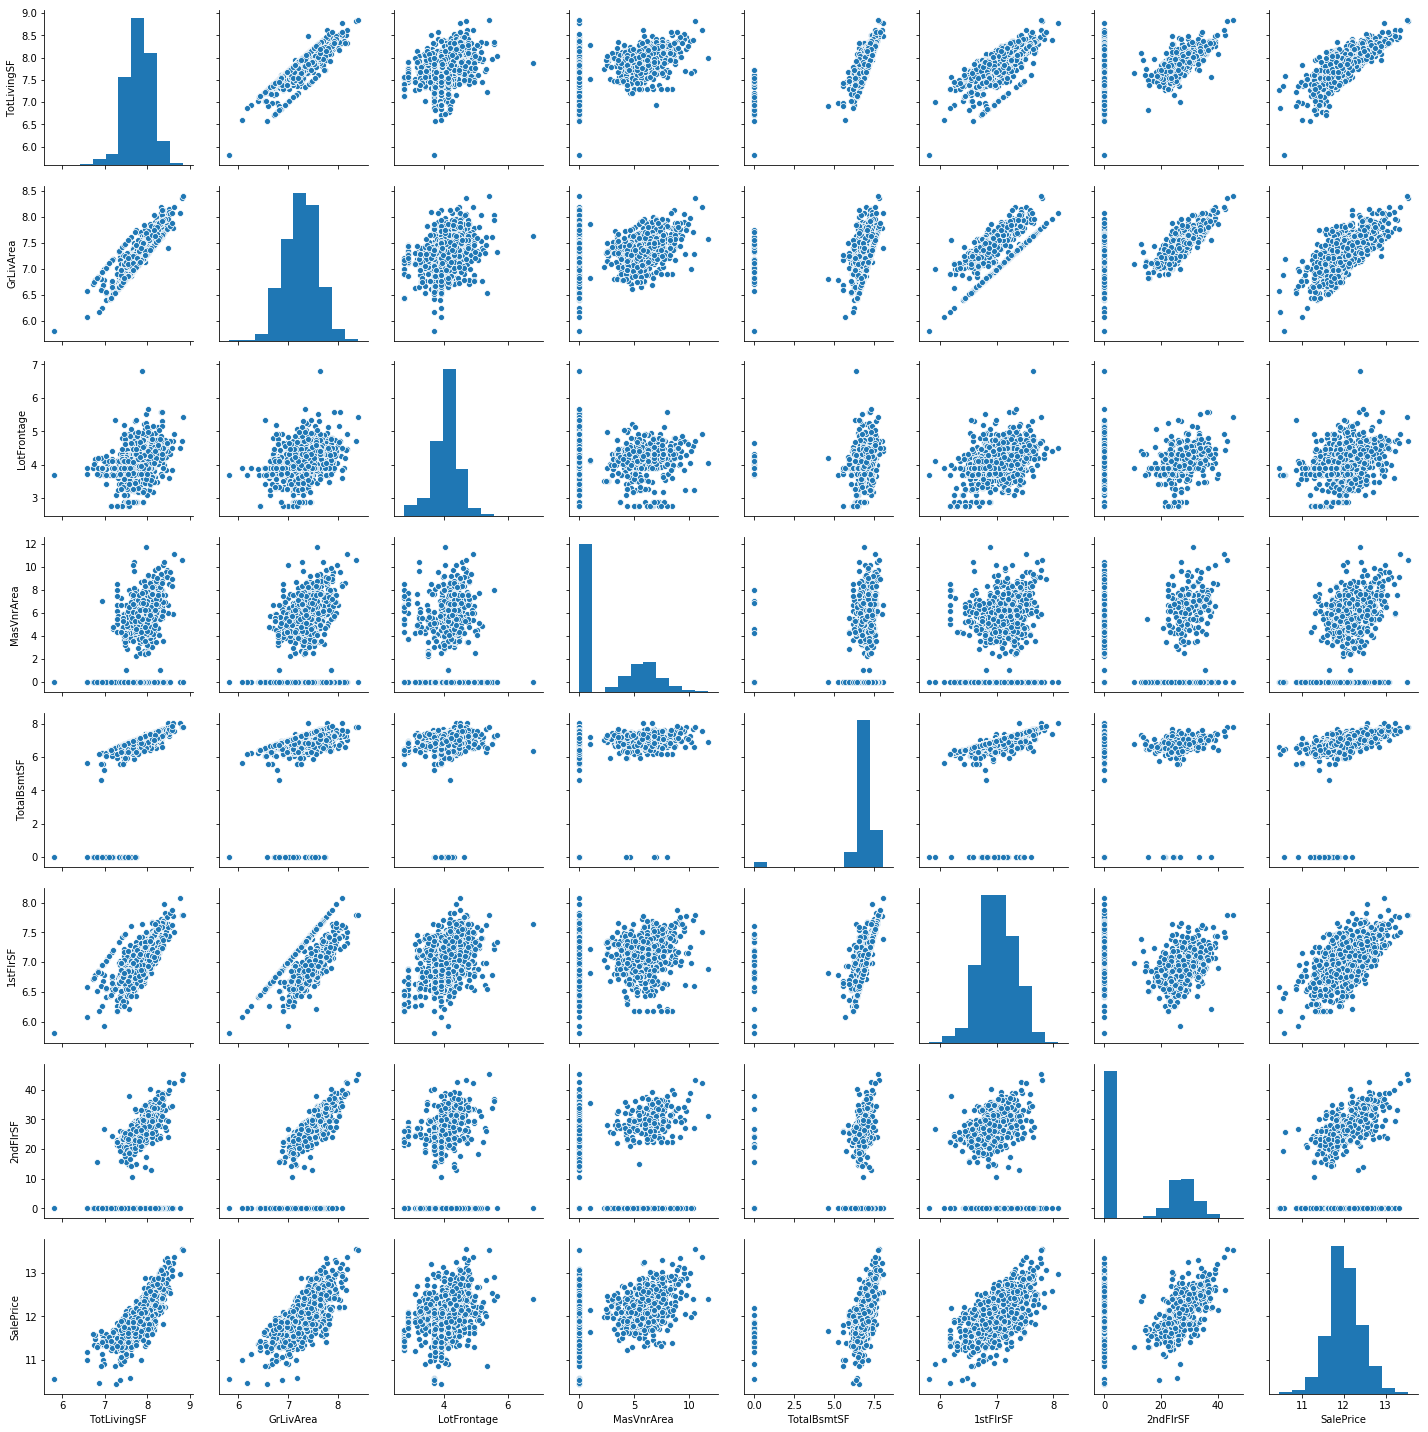

In [15]:
numerical_variables=training_data[["TotLivingSF","GrLivArea","LotFrontage","MasVnrArea","TotalBsmtSF","1stFlrSF","2ndFlrSF","SalePrice"]].copy()
numerical_variables[["TotLivingSF","GrLivArea","1stFlrSF","SalePrice"]] = np.log(numerical_variables[["TotLivingSF","GrLivArea","1stFlrSF","SalePrice"]])
# Perform logarithmic transformation on columns with 0s
numerical_variables["TotalBsmtSF"] = np.log(numerical_variables["TotalBsmtSF"].replace(0, np.nan))
numerical_variables.update(numerical_variables["TotalBsmtSF"].fillna(0))

numerical_variables["2ndFlrSF"] = np.sqrt(numerical_variables["2ndFlrSF"])

numerical_variables[["LotFrontage","MasVnrArea"]] = np.cbrt(numerical_variables[["LotFrontage","MasVnrArea"]])

sns.pairplot(numerical_variables)

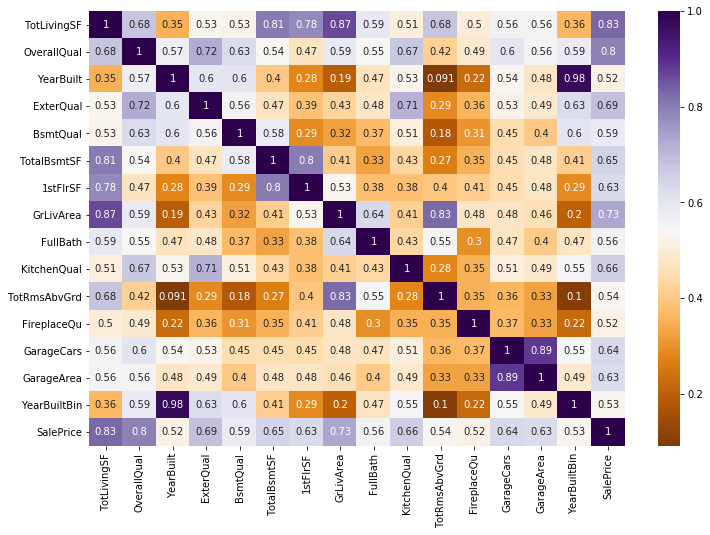

In [16]:
top_feature = training_data.corr().index[abs(training_data.corr()["SalePrice"]>0.5)]
plt.subplots(figsize = (12,8))
top_corr = training_data[top_feature].corr()
sns.heatmap(top_corr, annot=True, cmap="PuOr")
plt.show()

In [17]:
# Define the variables for the multiple linear regression
X_0 = data_encoded[["TotLivingSF","Neighborhood_Blueste","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NPkVill","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenQual","YearBuiltBin"]]
# X_0 = data_encoded[["TotLivingSF","Neighborhood_Blueste","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NPkVill","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","FullBath","HalfBath","BedroomAbvGr","KitchenQual","YearBuiltBin"]]
# Redefine X
X = X_0.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     296.6
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                 811.41
No. Observations:                1458   AIC:                            -1551.
Df Residuals:                    1422   BIC:                            -1361.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6442      0.152     50.136      0.000       7.345       7.943
x1             0.4513      0.021     21.920      0.000       0.411       0.492
x2            -0.0253      0.106     -0.238      0.812      -0.234       0.183
x3            -0.1212      0.052     -2.340      0.019      -0.223      -0.020
x4             0.0828      0.044      1.874      0.061      -0.004       0.169
x5             0.2125      0.046      4.664      0.000       0.123       0.302
x6             0.0833      0.037      2.256      0.024       0.011       0.156
x7             0.2341      0.043      5.394      0.000       0.149       0.319
x8             0.0209      0.041      0.513      0.608      -0.059       0.101
x9             0.1015      0.039      2.597      0.009       0.025       0.178
x10           -0.0984      0.047     -2.097      0.036      -0.190      -0.006
x11           -0.0872      0.051     -1.706      0.088      -0.188       0.013
x12            0.0686      0.042      1.649      0.099      -0.013       0.150
x13            0.0814      0.039      2.093      0.036       0.005       0.158
x14           -0.0071      0.060     -0.118      0.906      -0.124       0.110
x15            0.0729      0.040      1.816      0.070      -0.006       0.152
x16            0.1824      0.042      4.299      0.000       0.099       0.266
x17            0.1376      0.039      3.568      0.000       0.062       0.213
x18           -0.0309      0.043     -0.728      0.467      -0.114       0.052
x19            0.0646      0.050      1.287      0.198      -0.034       0.163
x20            0.0748      0.041      1.823      0.068      -0.006       0.155
x21            0.0566      0.040      1.414      0.158      -0.022       0.135
x22            0.0939      0.038      2.472      0.014       0.019       0.168
x23            0.1613      0.045      3.586      0.000       0.073       0.250
x24            0.1191      0.042      2.842      0.005       0.037       0.201
x25            0.1878      0.056      3.375      0.001       0.079       0.297
x26            0.0064      0.000     15.432      0.000       0.006       0.007
x27            0.0618      0.007      8.846      0.000       0.048       0.075
x28            0.0122      0.012      1.048      0.295      -0.011       0.035
x29            0.0665      0.008      8.208      0.000       0.051       0.082
x30            0.0509      0.016      3.178      0.002       0.019       0.082
x31            0.0456      0.010      4.374      0.000       0.025       0.066
x32            0.0526      0.009      6.151      0.000       0.036       0.069
x33            0.0017      0.006      0.284      0.777      -0.010       0.014
x34            0.0626      0.009      7.186      0.000       0.045       0.080
x35            0.0125      0.005      2.341      0.019       0.002       0.023
==

In [18]:
# Define the variables for the multiple linear regression
X_1 = data_encoded[["TotLivingSF","Neighborhood_Blueste","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill",
# Redefine X
X = X_1.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     305.5
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                 811.40
No. Observations:                1458   AIC:                            -1553.
Df Residuals:                    1423   BIC:                            -1368.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6398      0.148     51.643      0.000       7.350       7.930
x1             0.4514      0.021     21.985      0.000       0.411       0.492
x2            -0.0225      0.104     -0.217      0.828      -0.226       0.181
x3            -0.1185      0.046     -2.549      0.011      -0.210      -0.027
x4             0.0855      0.037      2.284      0.023       0.012       0.159
x5             0.2152      0.040      5.397      0.000       0.137       0.293
x6             0.0858      0.031      2.801      0.005       0.026       0.146
x7             0.2368      0.037      6.413      0.000       0.164       0.309
x8             0.0236      0.034      0.697      0.486      -0.043       0.090
x9             0.1040      0.033      3.185      0.001       0.040       0.168
x10           -0.0956      0.041     -2.359      0.018      -0.175      -0.016
x11           -0.0846      0.046     -1.842      0.066      -0.175       0.006
x12            0.0712      0.035      2.008      0.045       0.002       0.141
x13            0.0841      0.032      2.646      0.008       0.022       0.146
x14            0.0755      0.033      2.265      0.024       0.010       0.141
x15            0.1849      0.037      5.014      0.000       0.113       0.257
x16            0.1399      0.033      4.203      0.000       0.075       0.205
x17           -0.0282      0.035     -0.795      0.427      -0.098       0.041
x18            0.0675      0.044      1.529      0.127      -0.019       0.154
x19            0.0774      0.034      2.251      0.025       0.010       0.145
x20            0.0592      0.034      1.746      0.081      -0.007       0.126
x21            0.0963      0.032      3.002      0.003       0.033       0.159
x22            0.1637      0.040      4.060      0.000       0.085       0.243
x23            0.1216      0.036      3.341      0.001       0.050       0.193
x24            0.1903      0.051      3.700      0.000       0.089       0.291
x25            0.0064      0.000     15.437      0.000       0.006       0.007
x26            0.0618      0.007      8.849      0.000       0.048       0.075
x27            0.0123      0.012      1.063      0.288      -0.010       0.035
x28            0.0665      0.008      8.216      0.000       0.051       0.082
x29            0.0509      0.016      3.179      0.002       0.020       0.082
x30            0.0455      0.010      4.379      0.000       0.025       0.066
x31            0.0526      0.009      6.165      0.000       0.036       0.069
x32            0.0017      0.006      0.281      0.779      -0.010       0.014
x33            0.0626      0.009      7.197      0.000       0.046       0.080
x34            0.0126      0.005      2.376      0.018       0.002       0.023
==============================================================================
Om

In [19]:
# Define the variables for the multiple linear regression
X_2 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste",
# Redefine X
X = X_2.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     315.0
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                 811.38
No. Observations:                1458   AIC:                            -1555.
Df Residuals:                    1424   BIC:                            -1375.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6366      0.147     51.908      0.000       7.348       7.925
x1             0.4516      0.021     22.014      0.000       0.411       0.492
x2            -0.1166      0.046     -2.553      0.011      -0.206      -0.027
x3             0.0874      0.036      2.398      0.017       0.016       0.159
x4             0.2169      0.039      5.555      0.000       0.140       0.293
x5             0.0874      0.030      2.947      0.003       0.029       0.146
x6             0.2386      0.036      6.634      0.000       0.168       0.309
x7             0.0254      0.033      0.774      0.439      -0.039       0.090
x8             0.1057      0.032      3.336      0.001       0.044       0.168
x9            -0.0937      0.040     -2.368      0.018      -0.171      -0.016
x10           -0.0828      0.045     -1.833      0.067      -0.171       0.006
x11            0.0729      0.035      2.112      0.035       0.005       0.141
x12            0.0859      0.031      2.800      0.005       0.026       0.146
x13            0.0773      0.032      2.390      0.017       0.014       0.141
x14            0.1866      0.036      5.178      0.000       0.116       0.257
x15            0.1414      0.033      4.350      0.000       0.078       0.205
x16           -0.0263      0.034     -0.765      0.444      -0.094       0.041
x17            0.0694      0.043      1.604      0.109      -0.015       0.154
x18            0.0792      0.033      2.373      0.018       0.014       0.145
x19            0.0609      0.033      1.847      0.065      -0.004       0.126
x20            0.0979      0.031      3.137      0.002       0.037       0.159
x21            0.1652      0.040      4.169      0.000       0.087       0.243
x22            0.1233      0.036      3.464      0.001       0.053       0.193
x23            0.1921      0.051      3.781      0.000       0.092       0.292
x24            0.0064      0.000     15.441      0.000       0.006       0.007
x25            0.0617      0.007      8.850      0.000       0.048       0.075
x26            0.0124      0.012      1.069      0.285      -0.010       0.035
x27            0.0664      0.008      8.217      0.000       0.051       0.082
x28            0.0510      0.016      3.184      0.001       0.020       0.082
x29            0.0455      0.010      4.382      0.000       0.025       0.066
x30            0.0524      0.009      6.165      0.000       0.036       0.069
x31            0.0017      0.006      0.275      0.783      -0.010       0.013
x32            0.0626      0.009      7.206      0.000       0.046       0.080
x33            0.0127      0.005      2.388      0.017       0.002       0.023
==============================================================================
Omnibus:                      298.494   Durbin-Watson:                   1.956
Pr

In [20]:
# Define the variables for the multiple linear regression
X_3 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste","BedroomAbvGr"
# Redefine X
X = X_3.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     325.0
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                 811.34
No. Observations:                1458   AIC:                            -1557.
Df Residuals:                    1425   BIC:                            -1382.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6256      0.142     53.861      0.000       7.348       7.903
x1             0.4535      0.019     23.528      0.000       0.416       0.491
x2            -0.1155      0.045     -2.540      0.011      -0.205      -0.026
x3             0.0886      0.036      2.450      0.014       0.018       0.160
x4             0.2178      0.039      5.601      0.000       0.142       0.294
x5             0.0889      0.029      3.045      0.002       0.032       0.146
x6             0.2396      0.036      6.693      0.000       0.169       0.310
x7             0.0270      0.032      0.838      0.402      -0.036       0.090
x8             0.1071      0.031      3.425      0.001       0.046       0.168
x9            -0.0928      0.039     -2.353      0.019      -0.170      -0.015
x10           -0.0813      0.045     -1.814      0.070      -0.169       0.007
x11            0.0744      0.034      2.183      0.029       0.008       0.141
x12            0.0875      0.030      2.911      0.004       0.029       0.146
x13            0.0785      0.032      2.454      0.014       0.016       0.141
x14            0.1880      0.036      5.274      0.000       0.118       0.258
x15            0.1424      0.032      4.406      0.000       0.079       0.206
x16           -0.0253      0.034     -0.741      0.459      -0.092       0.042
x17            0.0714      0.043      1.674      0.094      -0.012       0.155
x18            0.0810      0.033      2.475      0.013       0.017       0.145
x19            0.0623      0.033      1.914      0.056      -0.002       0.126
x20            0.0989      0.031      3.191      0.001       0.038       0.160
x21            0.1656      0.040      4.183      0.000       0.088       0.243
x22            0.1245      0.035      3.529      0.000       0.055       0.194
x23            0.1924      0.051      3.790      0.000       0.093       0.292
x24            0.0064      0.000     15.459      0.000       0.006       0.007
x25            0.0617      0.007      8.849      0.000       0.048       0.075
x26            0.0122      0.012      1.054      0.292      -0.010       0.035
x27            0.0660      0.008      8.281      0.000       0.050       0.082
x28            0.0511      0.016      3.193      0.001       0.020       0.082
x29            0.0465      0.010      4.736      0.000       0.027       0.066
x30            0.0529      0.008      6.375      0.000       0.037       0.069
x31            0.0625      0.009      7.204      0.000       0.045       0.080
x32            0.0125      0.005      2.374      0.018       0.002       0.023
==============================================================================
Omnibus:                      298.683   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1128.637
Sk

In [21]:
# Define the variables for the multiple linear regression
X_4 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","ExterQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste","BedroomAbvGr","Neighborhood_OldTown",
# Redefine X
X = X_4.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     335.6
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                 811.06
No. Observations:                1458   AIC:                            -1558.
Df Residuals:                    1426   BIC:                            -1389.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6062      0.139     54.678      0.000       7.333       7.879
x1             0.4531      0.019     23.520      0.000       0.415       0.491
x2            -0.0980      0.039     -2.523      0.012      -0.174      -0.022
x3             0.1097      0.022      4.928      0.000       0.066       0.153
x4             0.2360      0.030      7.840      0.000       0.177       0.295
x5             0.1040      0.021      4.984      0.000       0.063       0.145
x6             0.2598      0.023     11.184      0.000       0.214       0.305
x7             0.0461      0.019      2.369      0.018       0.008       0.084
x8             0.1221      0.024      5.115      0.000       0.075       0.169
x9            -0.0711      0.026     -2.694      0.007      -0.123      -0.019
x10           -0.0635      0.038     -1.680      0.093      -0.138       0.011
x11            0.0911      0.026      3.553      0.000       0.041       0.141
x12            0.1062      0.016      6.502      0.000       0.074       0.138
x13            0.0956      0.022      4.296      0.000       0.052       0.139
x14            0.2037      0.029      7.097      0.000       0.147       0.260
x15            0.1565      0.026      6.009      0.000       0.105       0.208
x16            0.0930      0.031      2.997      0.003       0.032       0.154
x17            0.0991      0.022      4.552      0.000       0.056       0.142
x18            0.0783      0.024      3.221      0.001       0.031       0.126
x19            0.1132      0.024      4.675      0.000       0.066       0.161
x20            0.1806      0.034      5.307      0.000       0.114       0.247
x21            0.1398      0.029      4.889      0.000       0.084       0.196
x22            0.2094      0.045      4.622      0.000       0.121       0.298
x23            0.0064      0.000     15.477      0.000       0.006       0.007
x24            0.0619      0.007      8.879      0.000       0.048       0.076
x25            0.0122      0.012      1.058      0.290      -0.010       0.035
x26            0.0659      0.008      8.270      0.000       0.050       0.082
x27            0.0517      0.016      3.235      0.001       0.020       0.083
x28            0.0469      0.010      4.799      0.000       0.028       0.066
x29            0.0531      0.008      6.395      0.000       0.037       0.069
x30            0.0621      0.009      7.174      0.000       0.045       0.079
x31            0.0142      0.005      3.011      0.003       0.005       0.023
==============================================================================
Omnibus:                      300.155   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.034
Skew:                          -0.960   Prob(JB):                    1.52e-246
Ku

In [22]:
# Define the variables for the multiple linear regression
X_5 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste","BedroomAbvGr","Neighborhood_OldTown","ExterQual"
# Redefine X
X = X_5.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     346.7
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:40   Log-Likelihood:                 810.49
No. Observations:                1458   AIC:                            -1559.
Df Residuals:                    1427   BIC:                            -1395.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6228      0.138     55.150      0.000       7.352       7.894
x1             0.4539      0.019     23.585      0.000       0.416       0.492
x2            -0.1002      0.039     -2.582      0.010      -0.176      -0.024
x3             0.1103      0.022      4.957      0.000       0.067       0.154
x4             0.2347      0.030      7.803      0.000       0.176       0.294
x5             0.1049      0.021      5.032      0.000       0.064       0.146
x6             0.2604      0.023     11.213      0.000       0.215       0.306
x7             0.0460      0.019      2.366      0.018       0.008       0.084
x8             0.1222      0.024      5.121      0.000       0.075       0.169
x9            -0.0713      0.026     -2.701      0.007      -0.123      -0.020
x10           -0.0645      0.038     -1.708      0.088      -0.139       0.010
x11            0.0888      0.026      3.477      0.001       0.039       0.139
x12            0.1052      0.016      6.450      0.000       0.073       0.137
x13            0.0929      0.022      4.202      0.000       0.050       0.136
x14            0.2059      0.029      7.193      0.000       0.150       0.262
x15            0.1595      0.026      6.158      0.000       0.109       0.210
x16            0.0932      0.031      3.003      0.003       0.032       0.154
x17            0.0978      0.022      4.499      0.000       0.055       0.140
x18            0.0785      0.024      3.231      0.001       0.031       0.126
x19            0.1150      0.024      4.762      0.000       0.068       0.162
x20            0.1824      0.034      5.367      0.000       0.116       0.249
x21            0.1396      0.029      4.882      0.000       0.084       0.196
x22            0.2113      0.045      4.668      0.000       0.122       0.300
x23            0.0065      0.000     16.385      0.000       0.006       0.007
x24            0.0619      0.007      8.878      0.000       0.048       0.076
x25            0.0658      0.008      8.257      0.000       0.050       0.081
x26            0.0519      0.016      3.246      0.001       0.021       0.083
x27            0.0472      0.010      4.824      0.000       0.028       0.066
x28            0.0529      0.008      6.374      0.000       0.037       0.069
x29            0.0650      0.008      7.921      0.000       0.049       0.081
x30            0.0151      0.005      3.275      0.001       0.006       0.024
==============================================================================
Omnibus:                      297.294   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1118.118
Skew:                          -0.951   Prob(JB):                    1.60e-243
Kurtosis:                       6.845   Cond. No.                     1.66e+03
==

In [23]:
# Define the variables for the multiple linear regression
X_6 = data_encoded[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
# Removed because insignificant: "Neighborhood_NPkVill","Neighborhood_Blueste","BedroomAbvGr","Neighborhood_OldTown","ExterQual","Neighborhood_MeadowV"
# Redefine X
X = X_6.values
# Split data into training and testing set
# random_state ensures answers are reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
# fitting linear regressor to our training dataset
regressor.fit(X_train, y_train)
# Predicting the test set results
y_pred = regressor.predict(X_test)
# Build the optimal model using backward elimination
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)
# X_opt = X[:, [0,1]]
regressor_ols = sm.OLS(endog = y, exog = X).fit()
regressor_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     358.1
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        22:52:40   Log-Likelihood:                 809.00
No. Observations:                1458   AIC:                            -1558.
Df Residuals:                    1428   BIC:                            -1399.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6022      0.138     55.175      0.000       7.332       7.872
x1             0.4555      0.019     23.680      0.000       0.418       0.493
x2            -0.0890      0.038     -2.325      0.020      -0.164      -0.014
x3             0.1173      0.022      5.358      0.000       0.074       0.160
x4             0.2430      0.030      8.181      0.000       0.185       0.301
x5             0.1155      0.020      5.800      0.000       0.076       0.155
x6             0.2665      0.023     11.607      0.000       0.221       0.312
x7             0.0553      0.019      2.957      0.003       0.019       0.092
x8             0.1329      0.023      5.770      0.000       0.088       0.178
x9            -0.0645      0.026     -2.470      0.014      -0.116      -0.013
x10            0.0992      0.025      3.992      0.000       0.050       0.148
x11            0.1140      0.015      7.373      0.000       0.084       0.144
x12            0.1014      0.022      4.706      0.000       0.059       0.144
x13            0.2139      0.028      7.567      0.000       0.158       0.269
x14            0.1682      0.025      6.619      0.000       0.118       0.218
x15            0.0992      0.031      3.215      0.001       0.039       0.160
x16            0.1078      0.021      5.143      0.000       0.067       0.149
x17            0.0888      0.024      3.765      0.000       0.043       0.135
x18            0.1252      0.023      5.350      0.000       0.079       0.171
x19            0.1912      0.034      5.686      0.000       0.125       0.257
x20            0.1488      0.028      5.296      0.000       0.094       0.204
x21            0.2207      0.045      4.909      0.000       0.133       0.309
x22            0.0066      0.000     16.587      0.000       0.006       0.007
x23            0.0633      0.007      9.138      0.000       0.050       0.077
x24            0.0646      0.008      8.135      0.000       0.049       0.080
x25            0.0521      0.016      3.260      0.001       0.021       0.083
x26            0.0474      0.010      4.838      0.000       0.028       0.067
x27            0.0517      0.008      6.245      0.000       0.035       0.068
x28            0.0652      0.008      7.936      0.000       0.049       0.081
x29            0.0134      0.005      2.967      0.003       0.005       0.022
==============================================================================
Omnibus:                      293.898   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1092.893
Skew:                          -0.944   Prob(JB):                    4.80e-238
Kurtosis:                       6.798   Cond. No.                     1.65e+03
==============================================================================

W

Training Score: 0.8730511006368548
Testing Score: 0.8986539925078173
MSE: 0.017175570158083214


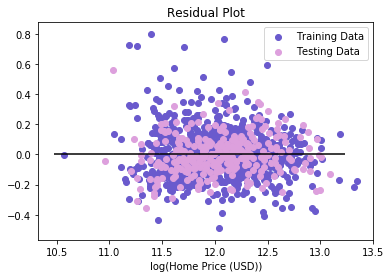

In [24]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
training_score = regressor.score(X_train, y_train)
testing_score = regressor.score(X_test, y_test)
MSE = mean_squared_error(y_test,y_pred)
### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print(f"MSE: {MSE}")
### BEGIN SOLUTION
# predictions = model.predict(X_test_scaled)
# model.fit(X_train_scaled, y_train_scaled)
# plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c="slateblue", label="Training Data")
plt.scatter(y_pred, y_pred - y_test, c="plum", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.xlabel("log(Home Price (USD))")
plt.show()
### END SOLUTION

## Competition Entry

In [25]:
# Load dataset
testing_data = pd.read_csv("02-cleaned_data/cleaned_testing.csv",index_col=0)

In [26]:

testing_data["TotLivingSF"] = testing_data["GrLivArea"] + testing_data["TotalBsmtSF"] - testing_data["LowQualFinSF"]

year_bins = [0,1920,1940,1960,1980,2000,2020]
year_groups = ["pre_1920","1920_1940","1940_1960","1960_1980","1980_2000","2000_up"]
testing_data["YearBuiltBin"] = pd.cut(testing_data["YearBuilt"],year_bins,labels=year_groups)

In [27]:
testing_data = testing_data[["MSSubClass","LotFrontage","LotArea","MasVnrArea","Neighborhood","OverallQual","OverallCond","YearBuilt","ExterQual","BsmtQual","BsmtCond","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","TotLivingSF","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","KitchenQual","TotRmsAbvGrd","Fireplaces","FireplaceQu","GarageType","GarageCars","GarageArea","GarageQual","GarageCond","PoolQC","YrSold","SaleCondition","YearBuiltBin"]]

In [28]:
data_encoded_testing = pd.get_dummies(testing_data,columns=["MSSubClass","Neighborhood","GarageType"])

In [29]:
# Perform logarithmic transformation on columns
data_encoded_testing[["TotLivingSF","GrLivArea","1stFlrSF"]] = np.log(data_encoded_testing[["TotLivingSF","GrLivArea","1stFlrSF"]])
# Perform logarithmic transformation on columns with 0s
data_encoded_testing["TotalBsmtSF"] = np.log(data_encoded_testing["TotalBsmtSF"].replace(0, np.nan))
data_encoded_testing.update(data_encoded_testing["TotalBsmtSF"].fillna(0))

# Perform square root transformation on relevant columns
data_encoded_testing["2ndFlrSF"] = np.sqrt(data_encoded_testing["2ndFlrSF"])

# Perform cube root transformation on relevant columns
data_encoded_testing[["LotFrontage","MasVnrArea"]] = np.cbrt(data_encoded_testing[["LotFrontage","MasVnrArea"]])

# Perform cube root transformation on relevant columns
data_encoded_testing["OverallQual"] = np.square(data_encoded_testing["OverallQual"])

In [30]:
data_encoded_testing["YearBuiltBin"].replace({"pre_1920":0,"1920_1940":1,"1940_1960":2,"1960_1980":3,"1980_2000":4,"2000_up":5},inplace=True)
data_encoded_testing["ExterQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
data_encoded_testing["BsmtQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
data_encoded_testing["KitchenQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
data_encoded_testing["FireplaceQu"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)
data_encoded_testing["GarageQual"].replace({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},inplace=True)

In [31]:
X_testing = data_encoded_testing[["TotLivingSF","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","OverallQual","GarageCars","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenQual","YearBuiltBin"]]
X_testing_values = X_testing.values
y_pred_testing = regressor.predict(X_testing_values)

In [32]:
testing_data["SalePrice"] = y_pred_testing
testing_data['SalePrice'] = np.exp(testing_data['SalePrice'])
kaggle_output = testing_data["SalePrice"]
kaggle_output.to_csv("03-kaggle_submission/multiple_variable_regression_solution.csv",header=True)